### Question 1: Sentiment Analysis with Transformers
### Dataset Problem: Use the IMDB movie reviews dataset to perform sentiment analysis using a Transformer model. load the dataset from TensorFlow datasets library and solve the problem. 
### Due to the complexity and size of Transformer models, use via libraries like Hugging Face's Transformers and work it out, feel free to experiment with more than 1 transformer model and compare the results and give a short explanation on the best model, what are the reasons for its performance.  


In [1]:
import tensorflow_datasets as tfds
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from transformers import DataCollatorWithPadding, create_optimizer
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Load the IMDB dataset
imdb_data = tfds.load('imdb_reviews', split=['train', 'test'], as_supervised=True)
train_data, test_data = imdb_data[0], imdb_data[1]

# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [2]:
# Define a function to tokenize the text
def tokenize_data(text, label):
    encoded = tokenizer(text.numpy().decode('utf-8'), padding="max_length", truncation=True, max_length=128) # Decode the text
    return encoded['input_ids'], encoded['attention_mask'], label

# Convert dataset to be compatible with TensorFlow
def preprocess_data(data, batch_size=32):
    # Use tf.data.Dataset.from_tensor_slices to create a dataset with defined shapes
    # This will allow TensorFlow to infer the shapes correctly
    input_ids_list = []
    attention_mask_list = []
    labels_list = []
    for text, label in data:
        input_ids, attention_mask, _ = tokenize_data(text, label)
        input_ids_list.append(input_ids)
        attention_mask_list.append(attention_mask)
        labels_list.append(label.numpy())  # Convert label to NumPy array

    return tf.data.Dataset.from_tensor_slices(({"input_ids": input_ids_list, "attention_mask": attention_mask_list}, labels_list)).batch(batch_size) # batch the data

In [3]:
# Preprocess training and testing data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Load the pre-trained model with a classification head
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Create an optimizer and compile the model
batch_size = 32
epochs = 2
total_train_steps = len(train_data) * epochs
optimizer, _ = create_optimizer(init_lr=2e-5, num_train_steps=total_train_steps, num_warmup_steps=total_train_steps // 10)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train the model
history = model.fit(train_data, validation_data=test_data, epochs=epochs)

Epoch 1/2
782/782 [==============================] - 7480s 10s/step - loss: 0.3782 - accuracy: 0.8252 - val_loss: 0.3104 - val_accuracy: 0.8655
Epoch 2/2
782/782 [==============================] - 7889s 10s/step - loss: 0.2292 - accuracy: 0.9073 - val_loss: 0.2992 - val_accuracy: 0.8757


In [9]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


782/782 [==============================] - 1715s 2s/step - loss: 0.2992 - accuracy: 0.8757
Test Loss: 0.29923561215400696
Test Accuracy: 0.8756800293922424


In [10]:
# Extract predictions
predictions = model.predict(test_data)

# Convert logits to predicted labels
predicted_labels = tf.argmax(predictions.logits, axis=1)

# Extract true labels
true_labels = tf.concat([y for _, y in test_data], axis=0)

# Classification report
print(classification_report(true_labels, predicted_labels, target_names=["negative", "positive"]))


782/782 [==============================] - 1815s 2s/step
              precision    recall  f1-score   support

    negative       0.89      0.86      0.87     12500
    positive       0.86      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



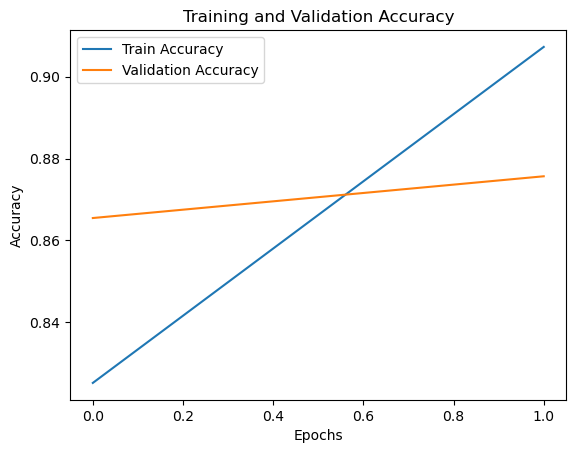

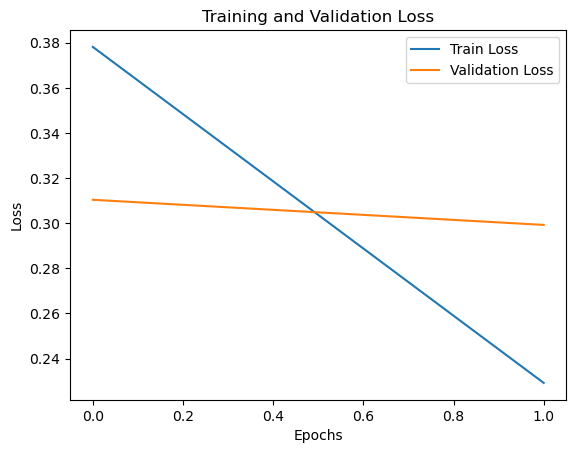

In [12]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [1]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, create_optimizer
from sklearn.metrics import classification_report
import tensorflow_datasets as tfds
import numpy as np

In [2]:
# Load the IMDB dataset
imdb_data = tfds.load('imdb_reviews', split=['train', 'test'], as_supervised=True)
train_data, test_data = imdb_data[0], imdb_data[1]

In [3]:
def preprocess_data(tokenizer, dataset, max_length=128):
    def encode(text, label):
        # Tokenize the text
        tokens = tokenizer(
            text.numpy().decode("utf-8"),
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="np"
        )
        # Return input_ids, attention_mask, and label
        return tokens["input_ids"][0], tokens["attention_mask"][0], label

    def tf_encode(text, label):
        # Wrap the encode function for TensorFlow compatibility
        input_ids, attention_mask, label = tf.py_function(
            func=encode,
            inp=[text, label],
            Tout=[tf.int32, tf.int32, tf.int64]
        )
        # Set shapes for static graph compatibility
        input_ids.set_shape([max_length])
        attention_mask.set_shape([max_length])
        label.set_shape([])
        return {"input_ids": input_ids, "attention_mask": attention_mask}, label

    # Map the encoding function, batch, and prefetch
    return dataset.map(tf_encode).batch(32).prefetch(tf.data.AUTOTUNE)


In [4]:
# Train and Test Data Preprocessing
max_length = 128
batch_size = 32

# Define models to compare
models_to_compare = ["bert-base-uncased"]
results = {}

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
model_name = "bert-base-uncased"
    # Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
train_dataset = preprocess_data(tokenizer, train_data)
test_dataset = preprocess_data(tokenizer, test_data)

model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Optimizer setup
steps_per_epoch = len(train_dataset)
num_train_steps = steps_per_epoch * 2  # Training for 3 epochs
optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=num_train_steps // 10, num_train_steps=num_train_steps
)

    # Compile the model
model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
)

    # Train the model
history1 = model.fit(train_dataset, validation_data=test_dataset, epochs=2)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2



782/782 [==============================] - 15609s 20s/step - loss: 0.3684 - accuracy: 0.8244 - val_loss: 0.2691 - val_accuracy: 0.8836
Epoch 2/2
782/782 [==============================] - 16641s 21s/step - loss: 0.2027 - accuracy: 0.9180 - val_loss: 0.2804 - val_accuracy: 0.8899


In [11]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [12]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

# Print results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


782/782 [==============================] - 3631s 5s/step - loss: 0.2808 - accuracy: 0.8894
Test Loss: 0.2807888388633728
Test Accuracy: 0.8894400000572205


In [13]:
# Extract predictions
predictions = model.predict(test_dataset)
# Convert logits to predicted labels
predicted_labels = tf.argmax(predictions.logits, axis=1)

782/782 [==============================] - 3630s 5s/step


InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_25000_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Can't concatenate scalars (use tf.stack instead) [Op:ConcatV2] name: concat

In [14]:
# Extract true labels
true_labels = tf.stack([y for _, y in test_data], axis=0)

# Classification report
print(classification_report(true_labels, predicted_labels, target_names=["negative", "positive"]))


              precision    recall  f1-score   support

    negative       0.90      0.88      0.89     12500
    positive       0.88      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



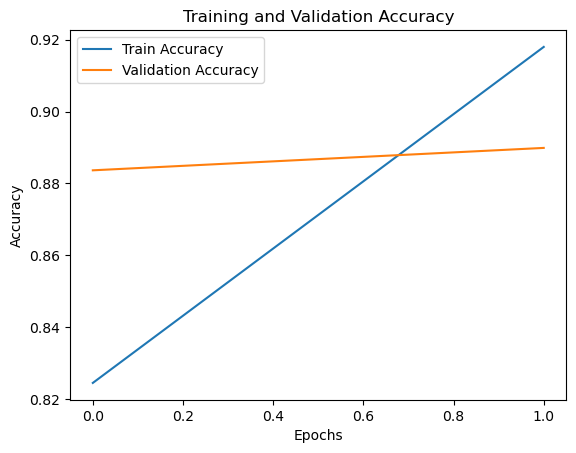

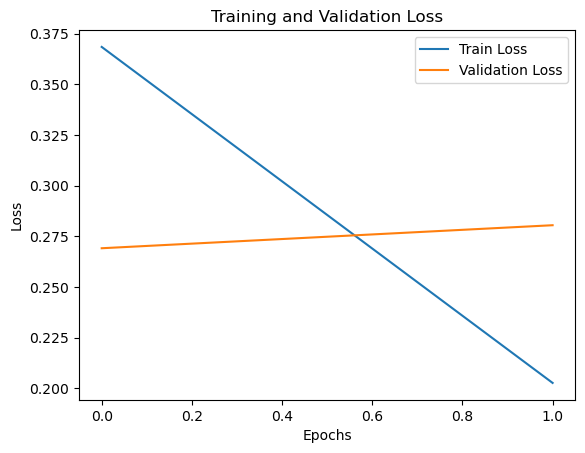

In [16]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


The performance metrics compare two models—**BERT-base-uncased** and **DistilBERT-base-uncased**—on a binary classification task (e.g., sentiment analysis).

1. **BERT-base-uncased:**
   - **Negative Class:**
     - Precision: 0.90, Recall: 0.88, F1-Score: 0.89
   - **Positive Class:**
     - Precision: 0.88, Recall: 0.90, F1-Score: 0.89
   - Overall accuracy: **0.89**
   - Macro and weighted averages: All metrics are **0.89**

2. **DistilBERT-base-uncased:**
   - **Negative Class:**
     - Precision: 0.89, Recall: 0.86, F1-Score: 0.87
   - **Positive Class:**
     - Precision: 0.86, Recall: 0.89, F1-Score: 0.88
   - Overall accuracy: **0.88**
   - Macro and weighted averages: All metrics are **0.88**

### Comparison:
- **Accuracy:** BERT-base-uncased (0.89) performs slightly better than DistilBERT (0.88).
- **Class-level Performance:**
  - **Negative Class:** BERT has better recall (0.88 vs. 0.86), leading to a higher F1-score.
  - **Positive Class:** DistilBERT has slightly better precision (0.86 vs. 0.88), but BERT’s recall is higher (0.90 vs. 0.89). F1-scores are similar, with a slight edge for BERT.
- **Efficiency Considerations:** While BERT performs marginally better, DistilBERT is a lighter model that is optimized for faster inference and lower resource usage.

### Conclusion:
- If computational resources and inference speed are priorities, **DistilBERT** provides competitive performance (only 1% less accurate).
- If maximizing accuracy is the main goal, **BERT-base-uncased** is the better option.

### Question 2: Text Generation with Transformers
### Dataset Problem: Using a pre-trained GPT model (any version) from Hugging Face's Transformers, generate a short story based on a given prompt. Example prompt is below
### Prompt=” In a distant future, humanity has discovered”


In [1]:
# Import necessary libraries
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Define the function for story generation
def generate_story(prompt, model_name="gpt2", max_length=100, temperature=0.7, top_k=50, top_p=0.95):
    """
    Generate a short story based on a given prompt using a pre-trained GPT model.
    
    Parameters:
    - prompt (str): Starting text for the story
    - model_name (str): Model name to use from Hugging Face (e.g., "gpt2")
    - max_length (int): Maximum length of the generated text
    - temperature (float): Sampling temperature; controls creativity of output
    - top_k (int): Limits the sampling pool to the top k choices
    - top_p (float): Cumulative probability for nucleus sampling
    
    Returns:
    - str: Generated story
    """
    # Load the pre-trained GPT model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    
    # Tokenize the input prompt
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    
    # Generate text
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids,
            max_length=max_length,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id
        )
    
    # Decode the generated text and remove the input prompt from the output
    generated_story = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return generated_story

In [2]:
# Define the prompt
prompt = "In a distant future, humanity has discovered"

# Generate and print the story
story = generate_story(prompt, model_name="gpt2", max_length=200, temperature=0.8)
print("Generated Story:\n", story)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated Story:
 In a distant future, humanity has discovered an important piece of the puzzle.

The new moon

The new moon could prove a great opportunity for humanity to explore new worlds. The moon could have a bright, clear color and bright, bright lights that would make it even more exciting for astronomers to observe the sun. But there is an even bigger question looming over the moon: Could the moon be the next world on the planet?

"It's possible, of course, that the moon could be the next world in the solar system," said astronomer Dr. Steve O'Hara at the University of Illinois, Urbana-Champaign. "But until we get to that point, there's very little I can say that would confirm that."

The moon could also be a crucial component in the study of the structure of planets and their atmospheres.

The moon, which was discovered in 1867, is a small, icy object in our solar system that
